About 9 months ago I wanted to create a Alexa app. So I did a sentiment analysis of several skills in the amazon store, little did I know this was actually data science so I attempted to build a career out of it.

In my previous attempt at sentiment analysis, I divided parts of speech like Adjectives, Nouns, and verbs so I can find the combination that would best describe the strengths and weaknesses of certain Alexa skills. I learned that the User experience in Alexa skills is most important. With Alexa, there is a feature called account linking, that requires the user to sign in with their phone via the Alexa app. And seeing all these people complain specifically about account linking, from both positive and negative perspectives was an interesting experience for me. 

Amazon merchants have a lot of products and reviews to sort through, that is why classification can easily give merchants the ability to sort by sentiment, by review length, and by star rating. Merchants can use these filtering methods to compare unsavory reviews and improve their customer service, product offering, and conflict resolution.

Textblob has the ability to create new features and that is quite useful when there are not a lot of CSV columns to choose from. Text bob was built on top of NLTK, which makes natural language processing easy to work with. Textblob can extract Sentiment, Polarity, and subjectivity. Textblob can also extract parts of speech and offers a light translation API connecting to Google translate.

The polarity is the emotion of the sentiment, a -1 polarity shows negative sentiment, a 0 polarity shows a neutral sentiment, and a 1 shows a positive sentiment.

The subjectivity shows how factual or objective a statement is. If the subjectivity is 0 then the phrase is stating a fact, if the subjectivity is 1 then the phrase is stating an opinion.

In sentiment analysis, the target is always the polarity, because the polarity will pair with the review feature to finetune the existing classification model for transfer learning.

We used a basic value counts to find the baseline of .79. Textblob also comes with its own linear and tree classifiers, this is the only way to transfer our models and minimize leakage. Our linear Naive Bayes model of .83 beats our baseline of .79, although the tree classification method is the same as baseline .79. Other methods outside this framework tend to overfit.

There are interesting insights that we get from building classification models. For example, matching the total amount of star reviews to a product. Visualizing the sentiment analysis as pos, neu, neg. Finding the frequency of the available words looks very interesting as well. All these Visualizations can be plugged into a web app and used to post-process csv's for amazon merchants.

The Model itself has a lot of use-cases, Textblob was originally trained off of Movie data, so finetuning eCommerce sentiment can have real-world application. Emojis were added just for fun. 😃

Lastly, I built a simple app to process CSV files, the app has only two functions, analyze sentiment as a string, and make an analysis for the entire CSV. This was difficult to make something so simple becuase plotly dash seems to be more lower level than javascript, and creating custom react components requires us to make an NPM library and pip library? I had to help other people who had the this issue. I think that plotly dash might be easier if new users stick with plotly.go components. There is room for improvement for the plotly ecosystem, Probably by simplifying components as lambda functions so they are smaller And easier boilerplates for new users to get used to.


## Import dataset using kaggle

In [ ]:
!pip install category_encoders==2.*
!pip install kaggle
!mkdir .kaggle


     |████████████████████████████████| 81kB 2.2MB/s 


In [ ]:
import json


token = {"username":"kenethrdige","key":"bc12da4417ac13efff956db114769ab5"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

Might have to run the below kaggle cell twice

In [ ]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d sid321axn/amazon-alexa-reviews
%cd /content/{/content}/datasets/sid321axn/amazon-alexa-reviews
!unzip \*.zip

- path is now set to: {/content}
  0% 0.00/164k [00:00<?, ?B/s]
100% 164k/164k [00:00<00:00, 63.8MB/s]
/content/{/content}/datasets/sid321axn/amazon-alexa-reviews
Archive:  amazon-alexa-reviews.zip
  inflating: amazon_alexa.tsv        


## data cleaning
Need to standardize these CSV with the headers:

**product, review, rating**



In [ ]:
import pandas as pd
df = pd.read_csv('amazon_alexa.tsv',sep="\t")
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [ ]:
df =df.rename(columns={"variation": "product"})
df =df.rename(columns={"verified_reviews": "review"})

In [ ]:
df.to_csv('alexa.csv')

In [ ]:
df.describe()

,rating,feedback
count,3150.000000,3150.000000
mean,4.463175,0.918413
std,1.068506,0.273778
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


### Create new features with text blob

A Sentiment analysis is a great way to create new features from natural language processing. 

#### Polarity
The polarity is the emotion, a -1 polarity shows negative sentiment, a 0 polarity shows a neutral sentiment, and a 1 shows a positive sentiment.

#### Subjectivity
The subjectivity shows how factual or objective a statement is. If the subjectivity is 0 then the phrase is stating a fact, if the subjectivity is 1 then the phrase is stating an opinion. 

In [ ]:
from textblob import TextBlob, Word, Blobber
from textblob.classifiers import NaiveBayesClassifier
from textblob.taggers import NLTKTagger
get_polarity = lambda words: TextBlob(words).sentiment.polarity
get_subjectivity = lambda words: TextBlob(words).sentiment.subjectivity

In [ ]:
testnlp = df['review'][0]
get_polarity(testnlp)


0.625

In [ ]:
get_subjectivity(testnlp)

0.6

In [ ]:
polarity = []
subjectivity = []
pol_target = []
conflict = []

def pos(rating):
  if rating != 4 | 5:
    conflict.append('1')
  else:
    conflict.append('0')


def neu(rating):
  if rating != 2 | 3 | 4:
    conflict.append('1')
  else:
    conflict.append('0')


def neg(rating):
  if rating != 1 | 2:
    conflict.append('1')
  else:
    conflict.append('0')

def check_conflict():
  for i, x in enumerate(df['review']):
    rating = df.iloc[i]['rating']
    polarity.append(get_polarity(x))
    # check if positive, if row rating is not 4 or 5 stars then add an conflict
    if get_polarity(x) >= 0.05:
      pos(rating)
      pol_target.append('pos')
      
    # check if neutral, if row rating is not 2 3 4 stars then add an conflict
    elif get_polarity(x) >= -0.05 < get_polarity(x) < 0.05:
      neu(rating)
      pol_target.append('neu')
    
    # Check if negative, if rating is not 1 or 2 starts then identify as conflict
    else:
      neg(rating)
      pol_target.append('neg')
    subjectivity.append(get_subjectivity(x))

check_conflict()


print(polarity)
print(subjectivity)
print(pol_target)
print(conflict)

[0.625, 0.875, -0.1, 0.35, 0.0, 0.29464285714285715, 0.21666666666666667, 0.2, 0.8, 0.98828125, 0.05, 0.4036458333333333, 0.00416666666666667, 0.59375, -0.1, 0.5, 0.6777777777777777, 0.12136363636363637, 0.178125, 0.15722222222222224, 0.2296875, 0.2722727272727273, 0.20357142857142857, 0.5, 0.05, 0.6000000000000001, 0.4, 0.8125, 0.16944444444444443, -0.125, 0.30999999999999994, 0.0, 0.3666666666666667, 0.2425925925925926, 1.0, 0.25, 0.6, 0.5, 0.39375, 0.3402597402597402, 0.5, 0.25, 0.39999999999999997, 0.21428571428571427, 0.8, 0.65, 0.45, 0.4, 0.35, 0.0, 0.0, 0.5, 0.55, 0.37, 0.5, 0.5, 0.5633333333333334, 0.5444444444444445, 0.5, 0.6, 0.0, 0.45833333333333337, 0.0, 0.5, 0.43, 0.43333333333333335, 0.3071428571428571, 0.0, 0.2, 0.6625, 0.37, 0.8, 0.5, 0.0, 0.0, 1.0, 0.27045454545454545, 0.7999999999999999, 0.0, 0.5, 0.17012310606060607, 0.0, 1.0, 0.35, 0.6510416666666667, 0.0, 0.10000000000000002, 0.4666666666666666, 0.1875, 0.8, 0.6333333333333333, 0.7, 0.55, 0.20000000000000004, 0.169

In [ ]:
# Merge lists
df_pol = pd.DataFrame(polarity,columns=['polarity'])
df_sub = pd.DataFrame(subjectivity,columns=['subjectivity'])
df_cat = pd.DataFrame(pol_target,columns=['pol_cat'])
df_conf = pd.DataFrame(conflict,columns=['pol_conflict'])
result = pd.concat([df, df_pol, df_sub, df_cat, df_conf], axis=1)
result

,rating,date,product,review,feedback,polarity,subjectivity,pol_cat,pol_conflict
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,0.625000,0.600000,pos,0
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,0.875000,0.800000,pos,0
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,-0.100000,0.512500,neg,1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,0.350000,0.450000,pos,0
4,5,31-Jul-18,Charcoal Fabric,Music,1,0.000000,0.000000,neu,1
...,...,...,...,...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1,1.000000,1.000000,pos,0
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check...",1,0.333333,0.452381,pos,0
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1,0.237662,0.533766,pos,0
3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1,0.316667,0.632099,pos,0


In [ ]:


# adding a length column for analyzing the length of the reviews

result['length'] = result['review'].apply(len)

result.groupby('length').describe().sample(10)



rating                           ... subjectivity                              
        count      mean       std  min  ...          25%       50%       75%       max
length                                  ...                                           
392       2.0  5.000000  0.000000  5.0  ...     0.700000  0.700000  0.700000  0.700000
307       2.0  2.000000  0.000000  2.0  ...     0.699735  0.699735  0.699735  0.699735
19       26.0  4.576923  0.856648  1.0  ...     0.000000  0.200000  0.600000  1.000000
512       1.0  5.000000       NaN  5.0  ...     0.396154  0.396154  0.396154  0.396154
451       4.0  2.500000  1.732051  1.0  ...     0.419643  0.421210  0.422778  0.422778
570       2.0  4.000000  0.000000  4.0  ...     0.263333  0.263333  0.263333  0.263333
861       1.0  5.000000       NaN  5.0  ...     0.532813  0.532813  0.532813  0.532813
55       11.0  4.000000  1.483240  1.0  ...     0.380556  0.550000  0.673810  0.800000
441       4.0  5.000000  0.000000  5.0  ...     0.533766  0.570887  0.608009  0.608009
229       3.0  5.000000  0.000000  5.0  ...     0.558333  0.666667  0.670000  0.673333

[10 rows x 32 columns]

In [ ]:
result.head()

,rating,date,product,review,feedback,polarity,subjectivity,pol_cat,pol_conflict,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,0.625,0.6000,pos,0,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,0.875,0.8000,pos,0,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,-0.100,0.5125,neg,1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,0.350,0.4500,pos,0,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,0.000,0.0000,neu,1,5


In [ ]:
one_hot = pd.get_dummies(df_cat['pol_cat'])
one_hot

,neg,neu,pos
0,0,0,1
1,0,0,1
2,1,0,0
3,0,0,1
4,0,1,0
...,...,...,...
3145,0,0,1
3146,0,0,1
3147,0,0,1
3148,0,0,1


In [ ]:
result = pd.concat([result, one_hot], axis=1)
result.head()

,rating,date,product,review,feedback,polarity,subjectivity,pol_cat,pol_conflict,length,neg,neu,pos
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,0.625,0.6000,pos,0,13,0,0,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,0.875,0.8000,pos,0,9,0,0,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,-0.100,0.5125,neg,1,195,1,0,0
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,0.350,0.4500,pos,0,172,0,0,1
4,5,31-Jul-18,Charcoal Fabric,Music,1,0.000,0.0000,neu,1,5,0,1,0


In [ ]:
result['pol_cat'].value_counts()

pos    2510
neu     489
neg     151
Name: pol_cat, dtype: int64

In [ ]:
import plotly.graph_objects as go

labels = result['product'].values.tolist()
values = result['rating'].values.tolist()
# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.6)])
fig.show()

## Parts of speech
Textblob is built off of NLTK, and for language processing it is easier to use.

In [ ]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [ ]:
blob = TextBlob(result['review'][5])

In [ ]:
blob.noun_phrases

WordList(['bluetooth', 'smart speaker', '’ t'])

## Baseline
Generally in a Sentiment analysis, the target will be the polarity because the insights we get from asking those questions will be valuable in making business decisions. To minimize leakage and make polarity usable as a target, we used a couple booleans to convert these continuous values into 3 discrete classes.

In [ ]:
y = result['pos']
import category_encoders as ce

def fastbaseline(in_df, in_target):
  target = in_target
  y_train = in_df[target]

  return y_train.value_counts(normalize=True)

fastbaseline(result, 'pos')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



1    0.796825
0    0.203175
Name: pos, dtype: float64

In [ ]:
fastbaseline(result, 'pol_cat')

pos    0.796825
neu    0.155238
neg    0.047937
Name: pol_cat, dtype: float64

In [ ]:
import plotly.graph_objects as go

x = result['pol_cat'].values.tolist()
y = result['rating'].values.tolist()

fig = go.Figure(data=[go.Pie(labels=x, values=y, hole=.6)])
fig.show()

### Test train split

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(result, test_size=0.20, random_state=42)
train.shape, test.shape

((2520, 13), (630, 13))

In [ ]:
train.head()

,rating,date,product,review,feedback,polarity,subjectivity,pol_cat,pol_conflict,length,neg,neu,pos
2310,5,30-Jul-18,Configuration: Fire TV Stick,Just the perfect cost effective solution. Tha...,1,0.800000,0.900000,pos,0,60,0,0,1
2189,5,30-Jul-18,Configuration: Fire TV Stick,I purchased the Fire Stick to be able to watch...,1,0.480000,0.645000,pos,0,194,0,0,1
2304,2,30-Jul-18,Configuration: Fire TV Stick,"I’m very unhappy with this Firestick, every ti...",0,0.001250,0.667500,neu,1,181,0,1,0
2988,4,30-Jul-18,White Dot,Handy if you don't expect much out of it much ...,1,0.333333,0.433333,pos,1,86,0,0,1
221,4,29-Jul-18,Charcoal Fabric,"Good quality, great sound quality",1,0.633333,0.583333,pos,1,33,0,0,1


In [ ]:
train = list(zip(train.review, train.pol_cat))
test = list(zip(test.review, test.pol_cat))

In [ ]:
train

[('Just the perfect cost effective solution.  Thank you Amazon.', 'pos'),
 ("I purchased the Fire Stick to be able to watch movies at my convenience. I love that there is such a variety of genres. I also enjoy it gives you the ability to watch TV shows too. It's Awesome!",
  'pos'),
 ('I’m very unhappy with this Firestick, every time we change programs or channels within a program there is a very long delay. We have 2 Roku’s That work just fine and are very quick.',
  'neu'),
 ('Handy if you don\'t expect much out of it much "dumber" than the assistant in my phone.',
  'pos'),
 ('Good quality, great sound quality', 'pos'),
 ('This is just like new -- same performance as our brand new one; no problems.',
  'pos'),
 ("No you tube wouldn't have bought it if I known that", 'neu'),
 ('Use it all the time and love it. Very quality product.', 'pos'),
 ('I sent it to my 85 year old Dad, and he talks to it constantly.', 'pos'),
 ('Echo Dot is a wonderful invention. We love it. Alexa is so smart

In [ ]:
test

[('Love it, we are still learning the capabilities, having a lot of fun.',
  'pos'),
 ('Very easy setup.', 'pos'),
 (' ', 'neu'),
 ('I purchased this on prime day mostly as a present for myself because I found having the echo plus on my kitchen counter to be overwhelming when cooking, cutting, cleaning, etc. especially when our counters aren’t very wide to begin with. After going back and forth between this and the show I decided on this because I felt it had all the same features but is more compact. I can honestly say I have no regrets. While I probably wouldn’t watch a movie I’d been dying to see on this, it’s a great way to listen to music, watch a quick YouTube video, etc. I even attempted watching “Jaws” on this and while it wasn’t the most comfortable thing for my eyes to do, it wasn’t as bad as one would think. I would definitely recommend!',
  'pos'),
 ('Fun and  information.  No dislikes  so far !! Like the convenience!!',
  'pos'),
 ('I am very pleased with the Fire Stick.',

## Finetuning Textblob classifier
Textblob has it's own classifiers to use specifically for NLP. Using this library's classification it reduces overfitting and leakage compared to other methods. The metrics here is .83 for our Linear Model, and .79 for our Classification model- beating our baseline of .78. 

In [ ]:
# Linear Model
from textblob.classifiers import NaiveBayesClassifier
cl = NaiveBayesClassifier(train)

nbc = cl.accuracy(test)

In [ ]:
nbc

0.834920634920635

This classification model takes an hour to train.

In [ ]:
# Classification model
from textblob.classifiers import DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(train)

dtc = dt_classifier.accuracy(test)

In [ ]:
dtc

0.792063492063492

In [ ]:
'scores', nbc, dtc

('scores', 0.834920634920635, 0.792063492063492)

In [ ]:
cl.classify("sentiment this")

'neu'

In [ ]:
cl.show_informative_features(20)  

Most Informative Features
          contains(poor) = True              neg : pos    =     46.8 : 1.0
          contains(case) = True              neg : pos    =     46.8 : 1.0
      contains(horrible) = True              neg : pos    =     36.4 : 1.0
      contains(confused) = True              neg : pos    =     36.4 : 1.0
         contains(reset) = True              neg : pos    =     34.3 : 1.0
         contains(stops) = True              neg : pos    =     28.1 : 1.0
        contains(starts) = True              neg : pos    =     28.1 : 1.0
           contains(bar) = True              neg : pos    =     26.0 : 1.0
          contains(dumb) = True              neg : pos    =     26.0 : 1.0
  contains(continuously) = True              neg : pos    =     26.0 : 1.0
           contains(act) = True              neg : pos    =     26.0 : 1.0
        contains(snooze) = True              neg : pos    =     26.0 : 1.0
       contains(Thought) = True              neg : pos    =     26.0 : 1.0

In [ ]:
import pickle as pickle
file = open('linear83.pickle','wb')
object = cl
pickle.dump(object,file)

In [ ]:
import pickle as pickle
file = open('classification79.pickle','wb')
object = dt_classifier
pickle.dump(object,file)

# Transfer this classifier on another dataset

In [ ]:
!kaggle datasets download -d eswarchandt/amazon-music-reviews
%cd /content/{/content}/datasets/eswarchandt/amazon-music-reviews
!unzip \*.zip
# say [y]es

  0% 0.00/4.69M [00:00<?, ?B/s]
100% 4.69M/4.69M [00:00<00:00, 76.4MB/s]
[Errno 2] No such file or directory: '/content/{/content}/datasets/eswarchandt/amazon-music-reviews'
/content/{/content}/datasets/sid321axn/amazon-alexa-reviews
Archive:  amazon-alexa-reviews.zip
replace amazon_alexa.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: amazon_alexa.tsv        


In [ ]:
%cd {/content}/datasets/eswarchandt/amazon-music-reviews



/content/{/content}/datasets/sid321axn/amazon-alexa-reviews/{/content}/datasets/eswarchandt/amazon-music-reviews


In [ ]:
!unzip \*.zip

Archive:  amazon-music-reviews.zip
  inflating: Musical_Instruments_5.json  
  inflating: Musical_instruments_reviews.csv  


In [ ]:
import pandas as pd
df = pd.read_csv('Musical_instruments_reviews.csv')
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [ ]:
df =df.rename(columns={"asin": "product"})
df =df.rename(columns={"reviewText": "review"})
df =df.rename(columns={"overall": "rating"})
df.head()

,reviewerID,product,reviewerName,helpful,review,rating,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [ ]:
import plotly.graph_objects as go

labels = df['product'].values.tolist()
values = df['rating'].values.tolist()
# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.6)])
fig.show()

In [ ]:
# important line that turns 
df['sentiment'] = df['review'].apply(lambda tweet: cl.classify(str(tweet)))

In [ ]:
df['emoji'] = df['sentiment']

In [ ]:
df['emoji'] = df['emoji'].replace({"pos": "😃", "neg": "😡", "neu": "😐"})

EMOJIS!!!

In [ ]:
df.head()

,reviewerID,product,reviewerName,helpful,review,rating,summary,unixReviewTime,reviewTime,sentiment,emoji
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014",neg,😡
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013",neg,😡
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013",pos,😃
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014",pos,😃
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014",pos,😃


In [ ]:
import plotly.graph_objects as go

x = df['sentiment'].values.tolist()
y = df['rating'].values.tolist()

fig = go.Figure(data=[go.Pie(labels=x, values=y, hole=.6)])
fig.show()


In [ ]:
negreview = df[df.sentiment != 'pos']

In [ ]:
negreview

,reviewerID,product,reviewerName,helpful,review,rating,summary,unixReviewTime,reviewTime,sentiment,emoji
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014",neg,😡
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013",neg,😡
7,AJNFQI3YR6XJ5,B00004Y2UT,"Fender Guy ""Rick""","[0, 0]",I now use this cable to run from the output of...,3.0,Didn't fit my 1996 Fender Strat...,1353024000,"11 16, 2012",neg,😡
10,A2NYK9KWFMJV4Y,B00004Y2UT,"Mike Tarrani ""Jazz Drummer""","[6, 6]","Monster makes a wide array of cables, includin...",5.0,One of the best instrument cables within the b...,1334793600,"04 19, 2012",neg,😡
15,A2PD27UKAD3Q00,B00005ML71,"Wilhelmina Zeitgeist ""coolartsybabe""","[0, 0]",I bought this to use with my keyboard. I wasn'...,2.0,Definitely Not For The Seasoned Piano Player,1376697600,"08 17, 2013",neg,😡
...,...,...,...,...,...,...,...,...,...,...,...
10255,A1TSKKBNV38E8Y,B00JBIVXGC,"K. Harriger ""K.R. Harriger""","[0, 0]",I have lots of friends who play these strings....,3.0,"Hmmm.... I like them, but with a lot of reserv...",1403654400,"06 25, 2014",neg,😡
10257,A1RPTVW5VEOSI,B00JBIVXGC,Michael J. Edelman,"[0, 0]",I've been thinking about trying the Nanoweb st...,5.0,"Long life, and for some players, a good econom...",1404259200,"07 2, 2014",neg,😡
10258,AWCJ12KBO5VII,B00JBIVXGC,Michael L. Knapp,"[0, 0]",I have tried coated strings in the past ( incl...,4.0,Good for coated.,1405987200,"07 22, 2014",neg,😡
10259,A2Z7S8B5U4PAKJ,B00JBIVXGC,"Rick Langdon ""Scriptor""","[0, 0]","Well, MADE by Elixir and DEVELOPED with Taylor...",4.0,Taylor Made,1404172800,"07 1, 2014",neg,😡


In [ ]:
#data["Name Length"]= data["Name"].str.len() 
negreview['length'] = negreview['review'].str.len()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
negreview.head()

,reviewerID,product,reviewerName,helpful,review,rating,summary,unixReviewTime,reviewTime,sentiment,emoji,length
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014",neg,😡,268.0
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013",neg,😡,544.0
7,AJNFQI3YR6XJ5,B00004Y2UT,"Fender Guy ""Rick""","[0, 0]",I now use this cable to run from the output of...,3.0,Didn't fit my 1996 Fender Strat...,1353024000,"11 16, 2012",neg,😡,845.0
10,A2NYK9KWFMJV4Y,B00004Y2UT,"Mike Tarrani ""Jazz Drummer""","[6, 6]","Monster makes a wide array of cables, includin...",5.0,One of the best instrument cables within the b...,1334793600,"04 19, 2012",neg,😡,1076.0
15,A2PD27UKAD3Q00,B00005ML71,"Wilhelmina Zeitgeist ""coolartsybabe""","[0, 0]",I bought this to use with my keyboard. I wasn'...,2.0,Definitely Not For The Seasoned Piano Player,1376697600,"08 17, 2013",neg,😡,623.0


In [ ]:
negreview = negreview.dropna()

In [ ]:
negreview.isnull().sum().sum()

0

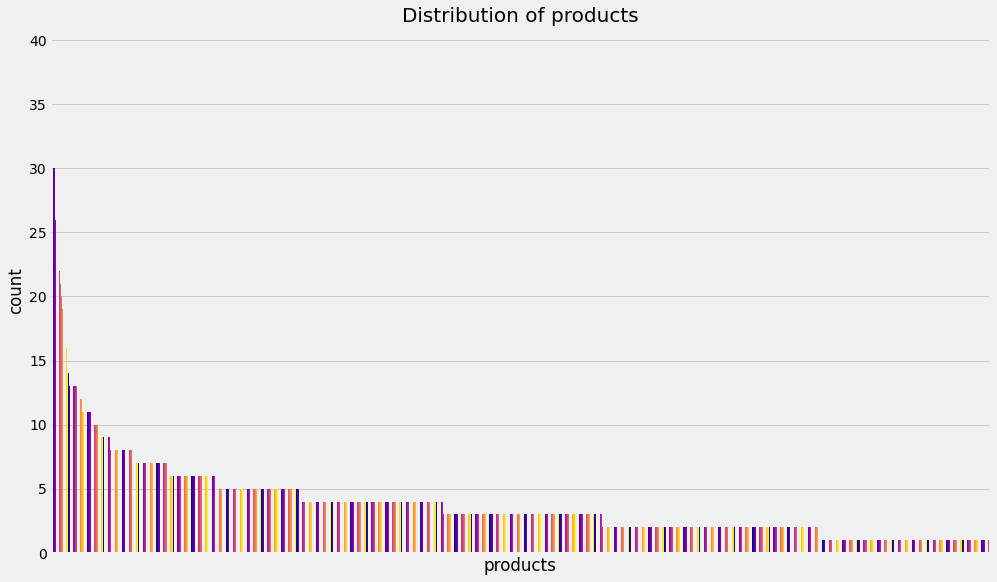

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


color = plt.cm.plasma(np.linspace(0, 1, 15))

negreview['product'].value_counts().plot.bar(color = color, figsize = (15, 9))

plt.title('Distribution of products', fontsize = 20)
plt.xticks(ticks=[],rotation=20)
plt.xlabel('products')
plt.ylabel('count')
plt.show()

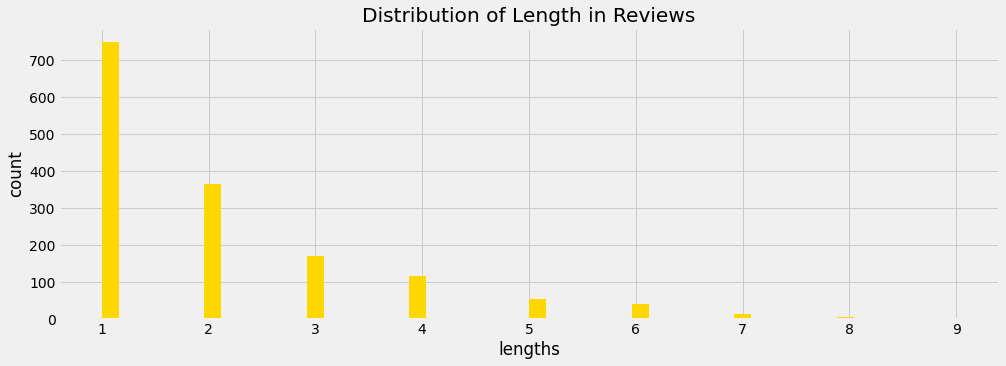

In [ ]:
negreview['length'].value_counts().plot.hist(color = 'gold', figsize = (15, 5), bins = 50)
plt.title('Distribution of Length in Reviews')
plt.xlabel('lengths')
plt.ylabel('count')
plt.show()

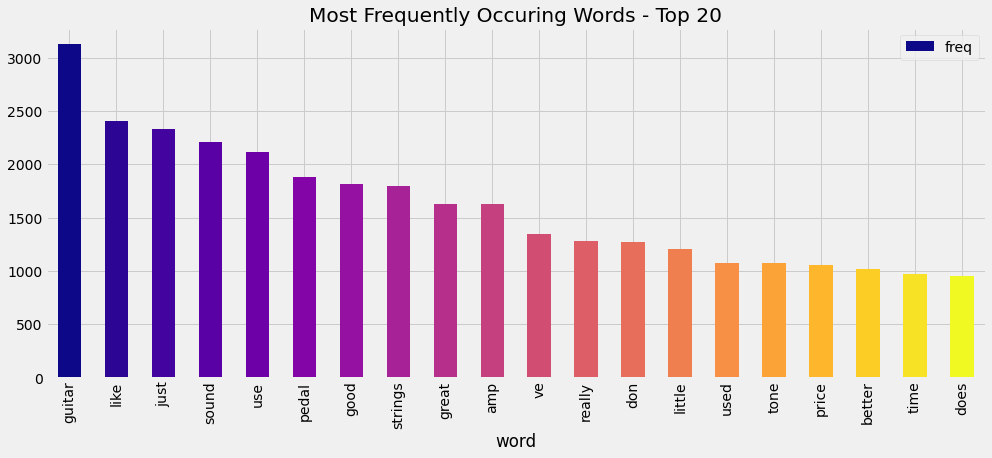

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(negreview.review)
sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

plt.style.use('fivethirtyeight')
color = plt.cm.plasma(np.linspace(0, 1, 20))
frequency.head(20).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
plt.title("Most Frequently Occuring Words - Top 20")
plt.show()

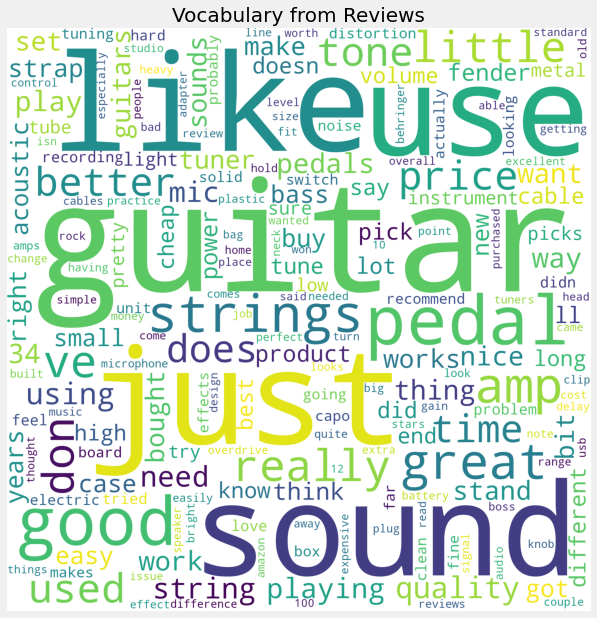

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color = 'white', width = 2000, height = 2000).generate_from_frequencies(dict(words_freq))

plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.title("Vocabulary from Reviews", fontsize = 20)
plt.show()